In [1]:
import numpy as np
import pandas as pd
import h5py
from data_helpers import timeseries_shuffler, split_data, format_timeseries
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
spikes_file = h5py.File('datasets/GRat31_636061_all_sorted_spikes.hdf5', 'r')
spikes_data = np.asarray(spikes_file['sorted_spikes'])[:,:10]
spikes_data.shape

(80690, 10)

In [3]:
all_head_data_h5 = h5py.File('datasets/GRat31_636061_all_head_data.hdf5', 'r')
# ['ax', 'ay', 'az', 'dx', 'dy', 'dz', 'ox', 'oy', 'oz']
idx_start, idx_stop = [3,6]
y = np.asarray([np.asarray(all_head_data_h5[key]) for key in all_head_data_h5.keys()][0:9]).T[:,idx_start:idx_stop][:,0]
print('y shape: ', y.shape)

head_data_keys = list(all_head_data_h5.keys())[0:9][idx_start:idx_stop]
head_data_keys_int = ['yaw_abs', 'roll_abs', 'pitch_abs']
print('head_data_keys intuitive: ', head_data_keys_int)

y shape:  (80690,)
head_data_keys intuitive:  ['yaw_abs', 'roll_abs', 'pitch_abs']


In [9]:
list(all_head_data_h5.keys())

['ax', 'ay', 'az', 'dx', 'dy', 'dz', 'ox', 'oy', 'oz']

array([<matplotlib.axes._subplots.AxesSubplot object at 0x2ad45c919fd0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x2ad45d23e358>], dtype=object)

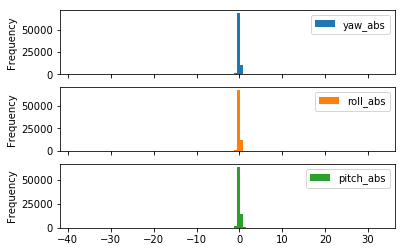

In [7]:
y_frame = pd.DataFrame(y)
y_frame.columns = head_data_keys_int
y_frame.plot.hist(subplots=True, bins=100)

In [14]:
def frame(them):
    return list(map(pd.DataFrame, them))

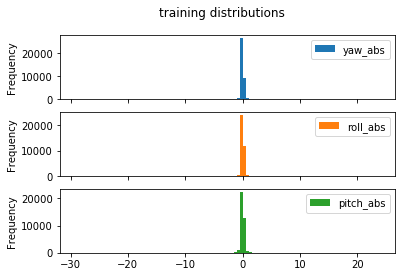

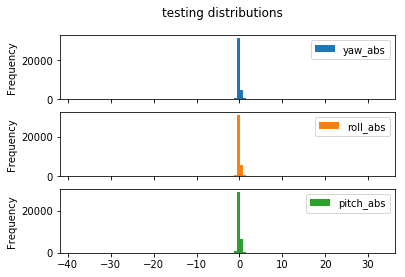

In [32]:
x1, y1 = timeseries_shuffler(spikes_data,y,600,50)
x1, x2, y1, y2 = frame(split_data(x1, y1, 0.5))
y1.columns = head_data_keys_int
y2.columns = head_data_keys_int
y1_plot = y1.plot.hist(subplots=True, bins=100, title="training distributions")
y2_plot = y2.plot.hist(subplots=True, bins=100, title="testing distributions")

In [30]:
def group_consecutives(vals, step=1):
    """Return list of consecutive lists of numbers from vals (number list)."""
    run = []
    result = [run]
    expect = None
    for v in vals:
        if (v == expect) or (expect is None):
            run.append(v)
        else:
            run = [v]
            result.append(run)
        expect = v + step
    return result

def get_turn_peaks(dx,threshold):
    ## ephys = samples x electrode channels
    crossings =  np.where(abs(dx) > threshold)[0]
    peaks = []
    grouped_crossings = group_consecutives(crossings)
    for idx,thing in enumerate(grouped_crossings):
        center = thing[np.argmax(abs(dx[thing]))]
        peaks.append(center)
        
    return peaks

def threshed_labels(X,y,threshold=.5):
    peaks = get_turn_peaks(y,threshold=threshold)

    X_peaks = X[peaks,:]

    labels = []
    for peak in peaks:
        if y[peak] > 0:
            labels.append(1)
        elif y[peak] < 0:
            labels.append(0)
    labels = np.array(labels)
    return X_peaks, labels

In [23]:
X_flat, X_test, dx, y_test = format_timeseries(spikes_data, y, 600, 10)
X_train.shape

(4345, 600, 10)

In [27]:
dx.shape

(4345,)

In [32]:
X_t, y = threshed_labels(X_flat,dx)
print(X_t.shape,y.shape)

(200, 600, 10) (200,)


In [40]:
peaks = get_turn_peaks(dx,threshold=.001)

y = dx[peaks]
X = X_flat[peaks,:]

labels = []
for peak in peaks:
    if dx[peak] > 0:
        labels.append(1)
    elif dx[peak] < 0:
        labels.append(0)
labels = np.array(labels)

print(labels.shape, X.shape)

(124,) (124, 600, 10)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x2b67f4430278>]], dtype=object)

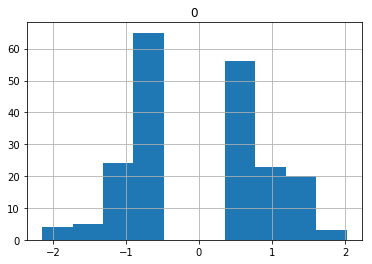

In [19]:
df_y = pd.DataFrame(y)
df_y.hist()

In [4]:
def sample_inv_dist(derivative, sample_size=10000, bins=10000):
    ################### sample the dx distribution evenly: ###################
    derivative = np.squeeze(derivative)
    hist,edges = np.histogram(derivative,bins=bins,normed=True)
    bins_where_values_from = np.searchsorted(edges,derivative)
    bin_weights = 1/(hist/sum(hist))
    inv_weights = bin_weights[bins_where_values_from-1]
    dx_idx = np.arange(0,len(derivative),1)
    sampled_dx_idx = np.random.choice(dx_idx,size=sample_size,replace=False,p=inv_weights/sum(inv_weights))
#     sampled_dx = np.random.choice(derivative,size=sample_size,replace=False,p=inv_weights/sum(inv_weights))
    
    return np.sort(sampled_dx_idx)

def resample_Xy(X,y,sample_size):
    resampled_idxs = sample_inv_dist(y,sample_size=sample_size)
    return X[resampled_idxs], y[resampled_idxs]

/n/regal/cox_lab/dapello/v1-decoder/data_helpers.py:147: RuntimeWarning: divide by zero encountered in true_divide
  bin_weights = 1/(hist/sum(hist))


X_train and y_train shape: (7400, 600, 10) (7400,)


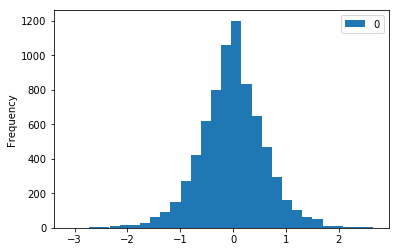

In [8]:
X_train, X_test, y_train, y_test = format_timeseries(spikes_data, y, 600, 10, resample_data=True, sample_size=10000)
pd.DataFrame(y_train).plot.hist(bins=30)

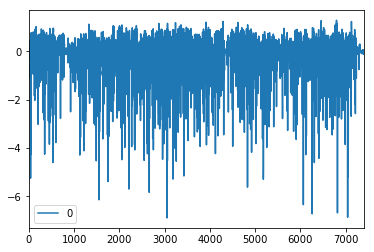

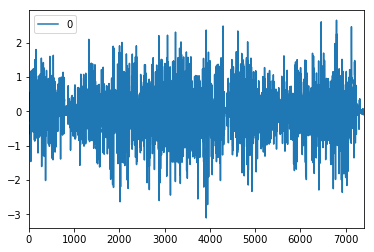

In [13]:
pd.DataFrame(np.log(np.abs(1+y_train))).plot()
pd.DataFrame(y_train).plot()